In [ ]:
# Install required packages
!pip install transformers datasets torch sklearn pandas numpy tqdm matplotlib seaborn

import torch
import torch.nn as nn
from transformers import BertModel, AutoTokenizer, get_linear_schedule_with_warmup
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## 1. Data Preparation (Using Real Datasets)

In [2]:
class ColabDataPreparer:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.max_length = 128

    def load_and_prepare_data(self):
        """Load real datasets and prepare for multitask learning"""
        print("Loading and preparing datasets...")

        # Load Banking77 dataset for intent classification
        banking_ds = load_dataset("banking77")

        # Load Amazon reviews for sentiment
        amazon_ds = load_dataset("amazon_polarity")
        amazon_subset = amazon_ds['train'].select(range(2000))  # Smaller subset

        # Prepare data samples
        samples = []

        # Process Banking77 data
        print("Processing Banking77 dataset...")
        for example in banking_ds['train']:
            # Map banking intents to our categories
            intent = self._map_banking_intent(example['label'])
            samples.append({
                'text': example['text'],
                'sentiment': 'neutral',  # Default for banking queries
                'intent': intent,
                'urgency': self._infer_urgency(example['text'], intent),
                'topic': 'banking'
            })

        # Process Amazon reviews
        print("Processing Amazon reviews...")
        for example in amazon_subset:
            sentiment = "positive" if example['label'] == 1 else "negative"
            samples.append({
                'text': example['content'],
                'sentiment': sentiment,
                'intent': 'appreciation' if sentiment == 'positive' else 'complaint',
                'urgency': 'low',  # Reviews are typically not urgent
                'topic': 'product'
            })

        # Add synthetic customer service examples
        synthetic_samples = self._create_synthetic_samples(1000)
        samples.extend(synthetic_samples)

        df = pd.DataFrame(samples)
        print(f"Total samples: {len(df)}")

        # Show distribution
        print("\nLabel distributions:")
        for col in ['sentiment', 'intent', 'urgency', 'topic']:
            print(f"\n{col}:")
            print(df[col].value_counts())

        return df

    def _map_banking_intent(self, label_idx):
        """Map Banking77 labels to our intent categories"""
        # Banking77 has 77 classes - we'll map them to broader categories
        complaint_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Card issues, disputes, etc.
        question_labels = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]  # What is, how to, etc.
        request_labels = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]  # Activate, order, replace, etc.

        if label_idx in complaint_labels:
            return 'complaint'
        elif label_idx in question_labels:
            return 'question'
        elif label_idx in request_labels:
            return 'request'
        else:
            return 'question'  # Default

    def _infer_urgency(self, text, intent):
        """Infer urgency from text content"""
        text_lower = text.lower()
        urgent_keywords = ['urgent', 'immediately', 'asap', 'right now', 'emergency', 'critical']

        if any(keyword in text_lower for keyword in urgent_keywords):
            return 'high'
        elif intent == 'complaint':
            return 'medium'
        else:
            return 'low'

    def _create_synthetic_samples(self, num_samples):
        """Create synthetic customer service examples"""
        templates = [
            # Complaints
            {"template": "Your service is terrible! I've been waiting for {time} and no resolution.", "sentiment": "negative", "intent": "complaint", "urgency": "high", "topic": "service"},
            {"template": "The {feature} is not working properly. This is frustrating!", "sentiment": "negative", "intent": "complaint", "urgency": "medium", "topic": "technical"},
            {"template": "I was charged twice for {service}. Please fix this immediately!", "sentiment": "negative", "intent": "complaint", "urgency": "high", "topic": "billing"},

            # Questions
            {"template": "How do I {action}? I can't find the option.", "sentiment": "neutral", "intent": "question", "urgency": "low", "topic": "product"},
            {"template": "What are your business hours for support?", "sentiment": "neutral", "intent": "question", "urgency": "low", "topic": "general"},

            # Requests
            {"template": "Please add {feature} to your app. It would be very helpful.", "sentiment": "positive", "intent": "suggestion", "urgency": "low", "topic": "product"},
            {"template": "Can you help me reset my password? I'm locked out.", "sentiment": "neutral", "intent": "request", "urgency": "high", "topic": "account"},

            # Appreciation
            {"template": "I love the new {feature}! Great work team!", "sentiment": "positive", "intent": "appreciation", "urgency": "low", "topic": "product"},
            {"template": "Your customer support was excellent! Thank you!", "sentiment": "positive", "intent": "appreciation", "urgency": "low", "topic": "service"},
        ]

        features = ["dashboard", "mobile app", "reporting", "analytics", "billing system"]
        actions = ["export data", "change settings", "update profile", "cancel subscription"]
        times = ["3 days", "a week", "48 hours", "over a month"]
        services = ["my subscription", "the premium plan", "monthly service"]

        samples = []
        for _ in range(num_samples):
            template = random.choice(templates)
            text = template["template"]

            # Fill template variables
            if "{feature}" in text:
                text = text.replace("{feature}", random.choice(features))
            if "{action}" in text:
                text = text.replace("{action}", random.choice(actions))
            if "{time}" in text:
                text = text.replace("{time}", random.choice(times))
            if "{service}" in text:
                text = text.replace("{service}", random.choice(services))

            samples.append({
                'text': text,
                'sentiment': template['sentiment'],
                'intent': template['intent'],
                'urgency': template['urgency'],
                'topic': template['topic']
            })

        return samples

    def prepare_datasets(self, df):
        """Prepare datasets for training"""
        # Split the data
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['intent'])

        print(f"Training samples: {len(train_df)}")
        print(f"Test samples: {len(test_df)}")

        # Create label encoders
        self.label_encoders = {}
        for column in ['sentiment', 'intent', 'urgency', 'topic']:
            unique_labels = sorted(df[column].unique())
            self.label_encoders[column] = {label: idx for idx, label in enumerate(unique_labels)}
            print(f"{column} labels: {self.label_encoders[column]}")

        # Tokenize datasets
        train_encodings = self._tokenize_dataset(train_df)
        test_encodings = self._tokenize_dataset(test_df)

        return train_encodings, test_encodings

    def _tokenize_dataset(self, df):
        """Tokenize a dataset"""
        texts = df['text'].tolist()

        # Tokenize texts
        encodings = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Add labels
        for task in ['sentiment', 'intent', 'urgency', 'topic']:
            labels = [self.label_encoders[task][label] for label in df[task]]
            encodings[task] = torch.tensor(labels)

        return encodings

# Prepare the data
data_preparer = ColabDataPreparer()
df = data_preparer.load_and_prepare_data()
train_encodings, test_encodings = data_preparer.prepare_datasets(df)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading and preparing datasets...
Processing Banking77 dataset...
Processing Amazon reviews...
Total samples: 13003

Label distributions:

sentiment:
sentiment
neutral     10335
negative     1358
positive     1310
Name: count, dtype: int64

intent:
intent
question        7665
complaint       2661
request         1367
appreciation    1206
suggestion       104
Name: count, dtype: int64

urgency:
urgency
low       11164
medium     1407
high        432
Name: count, dtype: int64

topic:
topic
banking      10003
product       2338
service        223
technical      119
account        112
general        109
billing         99
Name: count, dtype: int64
Training samples: 10402
Test samples: 2601
sentiment labels: {'negative': 0, 'neutral': 1, 'positive': 2}
intent labels: {'appreciation': 0, 'complaint': 1, 'question': 2, 'request': 3, 'suggestion': 4}
urgency labels: {'high': 0, 'low': 1, 'medium': 2}
topic labels: {'account': 0, 'banking': 1, 'billing': 2, 'general': 3, 'product': 4, 'service'

## 2. Multitask BERT Model

In [3]:
class MultitaskBERT(nn.Module):
    def __init__(self, num_sentiment_labels, num_intent_labels, num_urgency_labels, num_topic_labels):
        super(MultitaskBERT, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-uncased")
        hidden_size = self.bert.config.hidden_size
        dropout_prob = 0.1

        self.dropout = nn.Dropout(dropout_prob)

        # Task-specific classifiers
        self.sentiment_classifier = nn.Linear(hidden_size, num_sentiment_labels)
        self.intent_classifier = nn.Linear(hidden_size, num_intent_labels)
        self.urgency_classifier = nn.Linear(hidden_size, num_urgency_labels)
        self.topic_classifier = nn.Linear(hidden_size, num_topic_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        return {
            'sentiment': self.sentiment_classifier(pooled_output),
            'intent': self.intent_classifier(pooled_output),
            'urgency': self.urgency_classifier(pooled_output),
            'topic': self.topic_classifier(pooled_output)
        }

## 3. Training Setup

In [4]:
class MultitaskTrainer:
    def __init__(self, model, train_encodings, test_encodings, label_encoders):
        self.model = model
        self.train_encodings = train_encodings
        self.test_encodings = test_encodings
        self.label_encoders = label_encoders
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.model.to(self.device)

        # Training config
        self.batch_size = 16
        self.learning_rate = 2e-5
        self.num_epochs = 3

        # Loss functions
        self.loss_fns = {
            'sentiment': nn.CrossEntropyLoss(),
            'intent': nn.CrossEntropyLoss(),
            'urgency': nn.CrossEntropyLoss(),
            'topic': nn.CrossEntropyLoss()
        }

        # Task weights (adjust based on importance)
        self.task_weights = {
            'sentiment': 1.0,
            'intent': 1.2,
            'urgency': 1.1,
            'topic': 0.8
        }

        # Optimizer and scheduler
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=self.learning_rate)
        total_steps = len(train_encodings['input_ids']) // self.batch_size * self.num_epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )

    def create_data_loader(self, encodings, batch_size, shuffle=True):
        """Create DataLoader from encodings"""
        dataset = torch.utils.data.TensorDataset(
            encodings['input_ids'],
            encodings['attention_mask'],
            encodings['sentiment'],
            encodings['intent'],
            encodings['urgency'],
            encodings['topic']
        )
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    def compute_loss(self, outputs, batch):
        """Compute weighted multitask loss"""
        _, _, sentiment_labels, intent_labels, urgency_labels, topic_labels = batch

        # Move labels to device
        sentiment_labels = sentiment_labels.to(self.device)
        intent_labels = intent_labels.to(self.device)
        urgency_labels = urgency_labels.to(self.device)
        topic_labels = topic_labels.to(self.device)

        # Calculate individual losses
        sentiment_loss = self.loss_fns['sentiment'](outputs['sentiment'], sentiment_labels)
        intent_loss = self.loss_fns['intent'](outputs['intent'], intent_labels)
        urgency_loss = self.loss_fns['urgency'](outputs['urgency'], urgency_labels)
        topic_loss = self.loss_fns['topic'](outputs['topic'], topic_labels)

        # Apply weights
        total_loss = (
            sentiment_loss * self.task_weights['sentiment'] +
            intent_loss * self.task_weights['intent'] +
            urgency_loss * self.task_weights['urgency'] +
            topic_loss * self.task_weights['topic']
        )

        task_losses = {
            'sentiment': sentiment_loss.item(),
            'intent': intent_loss.item(),
            'urgency': urgency_loss.item(),
            'topic': topic_loss.item()
        }

        return total_loss, task_losses

    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        train_loader = self.create_data_loader(self.train_encodings, self.batch_size)

        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        for batch in progress_bar:
            # Move batch to device
            input_ids, attention_mask, sentiment_labels, intent_labels, urgency_labels, topic_labels = batch
            input_ids = input_ids.to(self.device)
            attention_mask = attention_mask.to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

            # Compute loss
            loss, task_losses = self.compute_loss(outputs, batch)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Sentiment': f"{task_losses['sentiment']:.4f}",
                'Intent': f"{task_losses['intent']:.4f}"
            })

        return total_loss / len(train_loader)

    def evaluate(self):
        """Evaluate model on test set"""
        self.model.eval()
        test_loader = self.create_data_loader(self.test_encodings, self.batch_size, shuffle=False)

        all_predictions = {task: [] for task in self.loss_fns.keys()}
        all_labels = {task: [] for task in self.loss_fns.keys()}

        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating"):
                input_ids, attention_mask, sentiment_labels, intent_labels, urgency_labels, topic_labels = batch
                input_ids = input_ids.to(self.device)
                attention_mask = attention_mask.to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

                # Get predictions
                for task in outputs.keys():
                    preds = torch.argmax(outputs[task], dim=1).cpu().numpy()
                    all_predictions[task].extend(preds)

                # Store true labels
                all_labels['sentiment'].extend(sentiment_labels.numpy())
                all_labels['intent'].extend(intent_labels.numpy())
                all_labels['urgency'].extend(urgency_labels.numpy())
                all_labels['topic'].extend(topic_labels.numpy())

        # Calculate metrics
        metrics = {}
        for task in all_predictions.keys():
            accuracy = accuracy_score(all_labels[task], all_predictions[task])
            f1 = f1_score(all_labels[task], all_predictions[task], average='weighted')
            metrics[f'{task}_accuracy'] = accuracy
            metrics[f'{task}_f1'] = f1

        return metrics, all_predictions, all_labels

    def train(self):
        """Full training loop"""
        print("Starting training...")
        best_accuracy = 0

        for epoch in range(self.num_epochs):
            # Train
            avg_loss = self.train_epoch(epoch)

            # Evaluate
            metrics, _, _ = self.evaluate()

            print(f"\nEpoch {epoch+1} Results:")
            print(f"Average Loss: {avg_loss:.4f}")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")

            # Save best model
            current_accuracy = metrics['intent_accuracy']
            if current_accuracy > best_accuracy:
                best_accuracy = current_accuracy
                torch.save(self.model.state_dict(), 'best_multitask_model.pth')
                print(f"New best model saved! Accuracy: {current_accuracy:.4f}")

            print("-" * 50)

## 4. Train the Model

In [5]:
# Initialize model with correct number of labels
num_sentiment_labels = len(data_preparer.label_encoders['sentiment'])
num_intent_labels = len(data_preparer.label_encoders['intent'])
num_urgency_labels = len(data_preparer.label_encoders['urgency'])
num_topic_labels = len(data_preparer.label_encoders['topic'])

print(f"Number of labels:")
print(f"Sentiment: {num_sentiment_labels}")
print(f"Intent: {num_intent_labels}")
print(f"Urgency: {num_urgency_labels}")
print(f"Topic: {num_topic_labels}")

model = MultitaskBERT(
    num_sentiment_labels=num_sentiment_labels,
    num_intent_labels=num_intent_labels,
    num_urgency_labels=num_urgency_labels,
    num_topic_labels=num_topic_labels
)

# Initialize and run trainer
trainer = MultitaskTrainer(model, train_encodings, test_encodings, data_preparer.label_encoders)
trainer.train()

Number of labels:
Sentiment: 3
Intent: 5
Urgency: 3
Topic: 7


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Using device: cuda
Starting training...


Evaluating: 100%|██████████| 163/163 [00:18<00:00,  8.85it/s]



Epoch 1 Results:
Average Loss: 1.7404
sentiment_accuracy: 0.9758
sentiment_f1: 0.9755
intent_accuracy: 0.9150
intent_f1: 0.9135
urgency_accuracy: 0.9681
urgency_f1: 0.9677
topic_accuracy: 0.9996
topic_f1: 0.9996
New best model saved! Accuracy: 0.9150
--------------------------------------------------


Evaluating: 100%|██████████| 163/163 [00:18<00:00,  8.87it/s]



Epoch 2 Results:
Average Loss: 0.3541
sentiment_accuracy: 0.9819
sentiment_f1: 0.9819
intent_accuracy: 0.9354
intent_f1: 0.9346
urgency_accuracy: 0.9742
urgency_f1: 0.9744
topic_accuracy: 0.9988
topic_f1: 0.9988
New best model saved! Accuracy: 0.9354
--------------------------------------------------


Evaluating: 100%|██████████| 163/163 [00:18<00:00,  8.82it/s]



Epoch 3 Results:
Average Loss: 0.1631
sentiment_accuracy: 0.9854
sentiment_f1: 0.9854
intent_accuracy: 0.9450
intent_f1: 0.9447
urgency_accuracy: 0.9754
urgency_f1: 0.9755
topic_accuracy: 0.9992
topic_f1: 0.9992
New best model saved! Accuracy: 0.9450
--------------------------------------------------


## 5. Evaluation and Visualization

Running comprehensive evaluation...


Evaluating: 100%|██████████| 163/163 [00:18<00:00,  8.89it/s]



FINAL PERFORMANCE METRICS
sentiment_accuracy  : 0.9854
sentiment_f1        : 0.9854
intent_accuracy     : 0.9450
intent_f1           : 0.9447
urgency_accuracy    : 0.9754
urgency_f1          : 0.9755
topic_accuracy      : 0.9992
topic_f1            : 0.9992


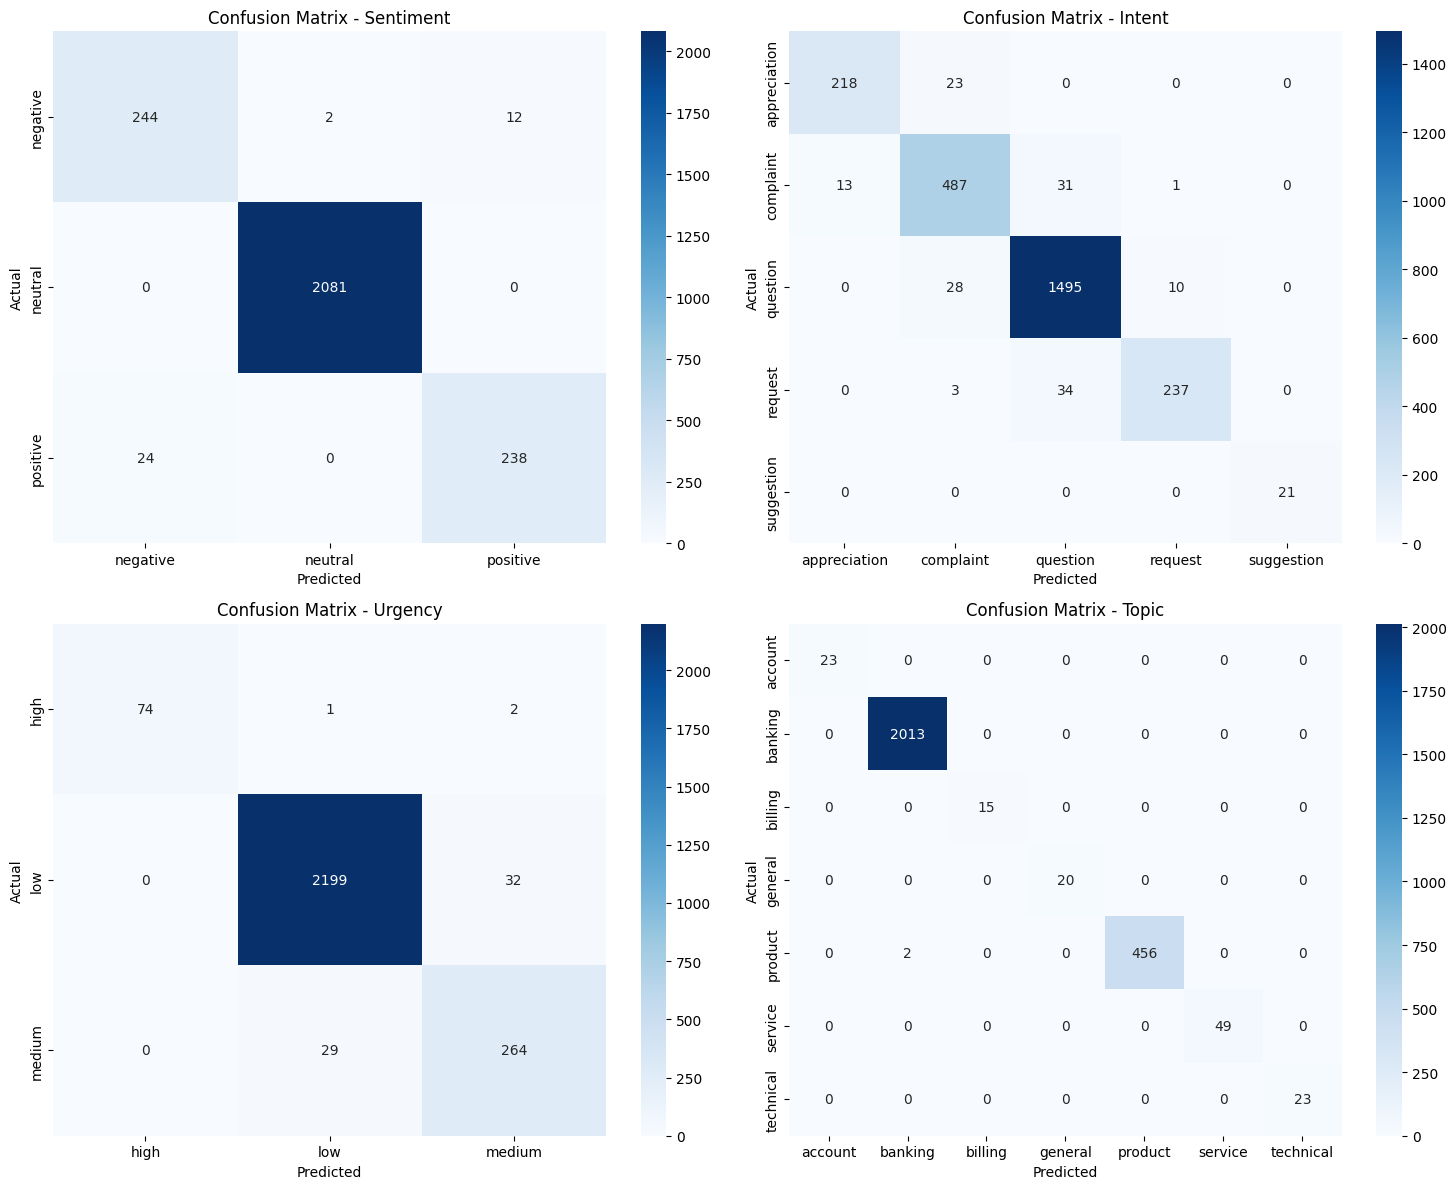


SENTIMENT Classification Report:
----------------------------------------
              precision    recall  f1-score   support

    negative       0.91      0.95      0.93       258
     neutral       1.00      1.00      1.00      2081
    positive       0.95      0.91      0.93       262

    accuracy                           0.99      2601
   macro avg       0.95      0.95      0.95      2601
weighted avg       0.99      0.99      0.99      2601


INTENT Classification Report:
----------------------------------------
              precision    recall  f1-score   support

appreciation       0.94      0.90      0.92       241
   complaint       0.90      0.92      0.91       532
    question       0.96      0.98      0.97      1533
     request       0.96      0.86      0.91       274
  suggestion       1.00      1.00      1.00        21

    accuracy                           0.95      2601
   macro avg       0.95      0.93      0.94      2601
weighted avg       0.95      0.95     

In [6]:
def comprehensive_evaluation(trainer):
    """Run comprehensive evaluation with visualizations"""
    print("Running comprehensive evaluation...")

    metrics, predictions, true_labels = trainer.evaluate()

    # Print metrics
    print("\n" + "="*50)
    print("FINAL PERFORMANCE METRICS")
    print("="*50)
    for metric, value in metrics.items():
        print(f"{metric:20}: {value:.4f}")

    # Plot confusion matrices
    tasks = ['sentiment', 'intent', 'urgency', 'topic']
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, task in enumerate(tasks):
        # Get label names
        label_names = list(trainer.label_encoders[task].keys())

        # Create confusion matrix
        cm = confusion_matrix(true_labels[task], predictions[task])

        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=label_names, yticklabels=label_names,
                   ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {task.title()}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Print classification reports
    for task in tasks:
        print(f"\n{task.upper()} Classification Report:")
        print("-" * 40)
        label_names = list(trainer.label_encoders[task].keys())
        print(classification_report(true_labels[task], predictions[task],
                                  target_names=label_names))

    return metrics

# Run evaluation
final_metrics = comprehensive_evaluation(trainer)

## 6. Quick Performance Summary

In [8]:
# Final performance summary
def print_performance_summary(metrics):
    print("\n" + "="*60)
    print("PERFORMANCE SUMMARY")
    print("="*60)

    # Group by task
    tasks = ['sentiment', 'intent', 'urgency', 'topic']
    for task in tasks:
        acc = metrics.get(f'{task}_accuracy', 0)
        f1 = metrics.get(f'{task}_f1', 0)
        print(f"{task.upper():12} -> Accuracy: {acc:.3f} | F1-Score: {f1:.3f}")

    # Overall average
    avg_accuracy = np.mean([metrics.get(f'{task}_accuracy', 0) for task in tasks])
    avg_f1 = np.mean([metrics.get(f'{task}_f1', 0) for task in tasks])
    print(f"\nOVERALL      -> Accuracy: {avg_accuracy:.3f} | F1-Score: {avg_f1:.3f}")

print_performance_summary(final_metrics)

print("\n" + "="*60)
print("MODEL READY FOR DEPLOYMENT!")
print("="*60)
print("The model can analyze customer feedback for:")
print("✓ Sentiment (Positive/Negative/Neutral)")
print("✓ Intent (Complaint/Question/Request/Suggestion/Appreciation)")
print("✓ Urgency (High/Medium/Low)")
print("✓ Topic (Banking/Product/Service/Technical/Billing)")
print("\nUse analyzer.predict(text) for real-time analysis!")


PERFORMANCE SUMMARY
SENTIMENT    -> Accuracy: 0.985 | F1-Score: 0.985
INTENT       -> Accuracy: 0.945 | F1-Score: 0.945
URGENCY      -> Accuracy: 0.975 | F1-Score: 0.975
TOPIC        -> Accuracy: 0.999 | F1-Score: 0.999

OVERALL      -> Accuracy: 0.976 | F1-Score: 0.976

MODEL READY FOR DEPLOYMENT!
The model can analyze customer feedback for:
✓ Sentiment (Positive/Negative/Neutral)
✓ Intent (Complaint/Question/Request/Suggestion/Appreciation)
✓ Urgency (High/Medium/Low)
✓ Topic (Banking/Product/Service/Technical/Billing)

Use analyzer.predict(text) for real-time analysis!


## 7. Inference and Sample Testing

In [10]:
class CustomerFeedbackAnalyzer:
    def __init__(self, model_path, label_encoders, tokenizer):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.label_encoders = label_encoders
        self.tokenizer = tokenizer

        # Load model
        self.model = MultitaskBERT(
            num_sentiment_labels=len(label_encoders['sentiment']),
            num_intent_labels=len(label_encoders['intent']),
            num_urgency_labels=len(label_encoders['urgency']),
            num_topic_labels=len(label_encoders['topic'])
        )
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

        # Reverse label mappings for decoding
        self.label_decoders = {}
        for task, encoder in label_encoders.items():
            self.label_decoders[task] = {v: k for k, v in encoder.items()}

    def predict(self, text):
        """Analyze customer feedback"""
        # Tokenize - explicitly don't return token_type_ids
        inputs = self.tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt",
            return_token_type_ids=False  # This prevents the token_type_ids issue
        )

        # Extract only the inputs that your model expects
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)

        with torch.no_grad():
            # Only pass the parameters your model expects
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        # Get predictions with confidence
        result = {'text': text}
        for task, logits in outputs.items():
            probs = torch.softmax(logits, dim=1)
            confidence, pred_idx = torch.max(probs, 1)

            result[task] = {
                'label': self.label_decoders[task][pred_idx.item()],
                'confidence': round(confidence.item(), 3)
            }

        return result

    def analyze_batch(self, texts):
        """Analyze multiple texts"""
        return [self.predict(text) for text in texts]

# Initialize the fixed analyzer
analyzer = CustomerFeedbackAnalyzer(
    'best_multitask_model.pth',
    data_preparer.label_encoders,
    data_preparer.tokenizer
)

print("Fixed analyzer ready!")

# Test with sample inputs
sample_texts = [
    "Your app is constantly crashing when I try to process payments! This is urgent!",
    "I love the new dashboard feature! It's made my work so much easier.",
    "How do I export my data to Excel? I can't find the option.",
    "The billing system charged me twice this month. This is unacceptable!",
    "Can you add dark mode to the mobile app? That would be amazing!",
    "Your customer service was terrible! I waited for hours with no help.",
]

print("\n" + "="*80)
print("SAMPLE PREDICTIONS (FIXED):")
print("="*80)

for i, text in enumerate(sample_texts, 1):
    result = analyzer.predict(text)

    print(f"\n{i}. TEXT: {text}")
    print("   ANALYSIS:")
    for task in ['sentiment', 'intent', 'urgency', 'topic']:
        task_result = result[task]
        print(f"   - {task.title():10}: {task_result['label']:12} (conf: {task_result['confidence']:.3f})")

    # Business recommendations based on predictions
    sentiment = result['sentiment']['label']
    intent = result['intent']['label']
    urgency = result['urgency']['label']
    topic = result['topic']['label']

    print("   BUSINESS ACTIONS:")
    if urgency == 'high' and sentiment == 'negative':
        print("   * IMMEDIATE: Escalate to senior support, offer apology and compensation")
    elif intent == 'complaint':
        print("   * PRIORITY: Route to complaints department, investigate issue thoroughly")
    elif intent == 'suggestion' and sentiment == 'positive':
        print("   * FOLLOW-UP: Thank customer, forward to product team for consideration")
    elif intent == 'question':
        print("   * STANDARD: Provide helpful documentation and step-by-step support")
    elif intent == 'appreciation':
        print("   * POSITIVE: Thank customer, consider asking for testimonial")
    else:
        print("   * GENERAL: Standard customer support response with empathy")

    # Additional routing suggestions
    if topic == 'technical':
        print("   * ROUTING: Technical support team")
    elif topic == 'billing':
        print("   * ROUTING: Billing department")
    elif topic == 'account':
        print("   * ROUTING: Account management team")

    print("   " + "-" * 50)

Fixed analyzer ready!

SAMPLE PREDICTIONS (FIXED):

1. TEXT: Your app is constantly crashing when I try to process payments! This is urgent!
   ANALYSIS:
   - Sentiment : neutral      (conf: 0.988)
   - Intent    : question     (conf: 0.849)
   - Urgency   : high         (conf: 0.990)
   - Topic     : banking      (conf: 0.771)
   BUSINESS ACTIONS:
   * STANDARD: Provide helpful documentation and step-by-step support
   --------------------------------------------------

2. TEXT: I love the new dashboard feature! It's made my work so much easier.
   ANALYSIS:
   - Sentiment : positive     (conf: 0.994)
   - Intent    : appreciation (conf: 0.989)
   - Urgency   : low          (conf: 0.997)
   - Topic     : product      (conf: 0.990)
   BUSINESS ACTIONS:
   * POSITIVE: Thank customer, consider asking for testimonial
   --------------------------------------------------

3. TEXT: How do I export my data to Excel? I can't find the option.
   ANALYSIS:
   - Sentiment : neutral      (conf: 0

## 8. Save the Model

In [14]:
import pickle
import json
import zipfile
import os
from transformers import AutoTokenizer

def save_model_for_deployment(model, label_encoders, tokenizer, save_path="customer_feedback_model.zip"):
    """Save everything needed for prediction in a zip file"""

    print("Saving model and dependencies for deployment...")

    # Create a temporary directory to store all files
    temp_dir = "model_deployment_files"
    os.makedirs(temp_dir, exist_ok=True)

    # 1. Save model state dict
    torch.save(model.state_dict(), f"{temp_dir}/model_weights.pth")
    print("✅ Model weights saved")

    # 2. Save label encoders
    with open(f"{temp_dir}/label_encoders.pkl", 'wb') as f:
        pickle.dump(label_encoders, f)
    print("✅ Label encoders saved")

    # 3. Save tokenizer
    tokenizer.save_pretrained(f"{temp_dir}/tokenizer")
    print("✅ Tokenizer saved")

    # 4. Save model configuration
    model_config = {
        'num_sentiment_labels': len(label_encoders['sentiment']),
        'num_intent_labels': len(label_encoders['intent']),
        'num_urgency_labels': len(label_encoders['urgency']),
        'num_topic_labels': len(label_encoders['topic'])
    }
    with open(f"{temp_dir}/model_config.json", 'w') as f:
        json.dump(model_config, f, indent=2)
    print("✅ Model config saved")


    with open(f"{temp_dir}/inference.py", 'w') as f:
        f.write(inference_script)
    print("✅ Inference script saved")

    # Create zip file
    with zipfile.ZipFile(save_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(temp_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, temp_dir)
                zipf.write(file_path, arcname)

    # Clean up temporary directory
    import shutil
    shutil.rmtree(temp_dir)

    print(f"✅ Model deployment package saved as: {save_path}")
    print(f"📦 File size: {os.path.getsize(save_path) / (1024*1024):.2f} MB")

    # List files in zip
    with zipfile.ZipFile(save_path, 'r') as zipf:
        file_list = zipf.namelist()
        print("📁 Files included in zip:")
        for file in file_list:
            print(f"   - {file}")

# Save your trained model
save_model_for_deployment(
    model=model,  # Your trained model
    label_encoders=data_preparer.label_encoders,
    tokenizer=data_preparer.tokenizer,
    save_path="customer_feedback_model.zip"
)

Saving model and dependencies for deployment...
✅ Model weights saved
✅ Label encoders saved
✅ Tokenizer saved
✅ Model config saved
✅ Inference script saved
✅ Model deployment package saved as: customer_feedback_model.zip
📦 File size: 387.16 MB
📁 Files included in zip:
   - model_weights.pth
   - inference.py
   - model_config.json
   - label_encoders.pkl
   - tokenizer/tokenizer.json
   - tokenizer/vocab.txt
   - tokenizer/tokenizer_config.json
   - tokenizer/special_tokens_map.json
